In [1]:
import sys
import numpy as np
from scipy.stats import spearmanr
sys.path.insert(0,'..')
from cider.fairness import *
from cider.targeting import *
EXCHANGE_RATE = 572.269

In [2]:
outcomes = pd.read_csv('/data/togo_anon/surveys/survey2018outcomes_with_milieu.csv')
outcomes = outcomes[['hhid', 'phone_number', 'weight', 'cons_basket', 'ppi_cons_basket', 'assetindex',
                    'region', 'prefecture', 'canton', 'milieu']]\
    .rename({'cons_basket':'consumption', 'ppi_cons_basket':'pmt'}, axis=1)
outcomes['consumption'] = outcomes['consumption']/(365*EXCHANGE_RATE)
outcomes['pmt'] = outcomes['pmt']/(365*EXCHANGE_RATE)
outcomes['weight'] = outcomes['weight']/outcomes['weight'].min()
print('Observations in survey: %i' % len(outcomes))
predictions = pd.read_csv('/data/togo_anon/paper/ml/2018/consumption/LGBM/oos_predictions.csv')
print('Observations in CDR: %i (%i unique)' % (len(predictions), 
                                               len(predictions.drop_duplicates(subset='phone_number'))))
predictions = predictions.drop_duplicates(subset=['phone_number'])[['phone_number', 'predicted']]\
    .rename({'predicted':'cdr'}, axis=1)
print('Observations with predictions: %i' % len(predictions))
predictions['cdr'] = np.exp(predictions['cdr'])/(365*EXCHANGE_RATE)
df = outcomes.merge(predictions, on='phone_number')
print('Final observations in combined dataframe: %i (%i unique)' % (len(df), len(df['phone_number'].unique())))
prefecture_wealth = pd.read_csv('/data/togo_anon/surveys/survey2017/2017_prefecture_poverty.csv')\
    .rename({'poverty':'prefecture_wealth'}, axis=1)
prefecture_wealth['prefecture_wealth'] = 100 - prefecture_wealth['prefecture_wealth']
canton_wealth = pd.read_csv('/data/togo_anon/satellite/cantons_sat_dhs.csv')\
    [['Id', 'Estimated wealth index (population-weighted)']]\
    .rename({'Estimated wealth index (population-weighted)':'canton_wealth', 'Id':'canton'}, axis=1)
df = df.merge(prefecture_wealth, on=['prefecture'], how='left')\
    .merge(canton_wealth, on=['canton'], how='left')
occupations = pd.read_csv('/data/togo_anon/surveys/survey2018/occupation.csv')\
    [['hhid', 'hinformal']].rename({'hinformal':'formal_occupation'}, axis=1)
occupations['formal_occupation'] = 1 - occupations['formal_occupation'].fillna(0)
df = df.merge(occupations, on='hhid')
np.random.seed(1)
df['random'] = np.random.rand(len(df))
df = df.rename({'hhid':'uid'}, axis=1)
df2018 = df.copy()
demographics = pd.read_csv('/data/togo_anon/surveys/survey2018/demographics.csv')\
    .rename({'hhid':'uid'}, axis=1)
demographics = demographics[['uid', 'ethnie', 'sexe', 'religion', 'age', 'handig', 'mstat']]
demographics['gender'] = demographics['sexe'].apply(lambda x: 'Male' if x == 'Masculin' else 'Female')
demographics['age_group'] = demographics['age']\
    .apply(lambda x: '<30' if x < 30 else '30-40' if x < 40 else '40-50' if x < 50 else '50-60' if x < 60
          else '60+' if x < 60 else '60+' if x < 150 else np.nan)
demographics['religion'] = demographics['religion']\
    .apply(lambda x: 'Islam' if x == 'Musulman' else 'Christianity' if x == 'Chrétien' else 'Animism' if 
          x == 'Animiste' else 'Other/None')
demographics['ethnicity'] = demographics['ethnie']\
    .apply(lambda x: 'Ewé' if x == 'Ewé' else 'Kabyè' if x == 'Kabyè' else 'Moba' if x == 'Moba' else 'Kotokoli' 
           if x == 'Kotokoli' else 'Other')
demographics['disability'] = demographics['handig'].apply(lambda x: 'Yes' if x == 'Oui' else 'No')
demographics['marital_status'] = demographics['mstat']\
    .apply(lambda x: 'Single' if x == 'Célibataire' 
           else 'Marriage (Polygamous)' if x == 'Marié(e) polygame'
          else 'Marriage (Monogamous)' if x in ['Marié(e) monogame', 'Union libre']
          else 'Widow/Widower' if x == 'Veuf(ve)'
          else 'Divorced/Separated')
demographics = demographics[['uid', 'gender', 'religion', 'age_group', 'ethnicity', 'disability', 
                             'marital_status']]
children = pd.read_csv('/data/togo_anon/surveys/survey2018/survey20182019.csv')
children = children[['hhid', 'nb_child16']].rename({'hhid':'uid'}, axis=1)
children['children'] = children['nb_child16'].apply(lambda x: '0' if x == 0 else '1-2' if x <= 2 else '3-4'
                                                   if x <= 4 else '5+')
children = children[['uid', 'children']]
demographics = demographics.merge(children, on='uid', how='inner')

demographics['vulnerable'] = ((demographics['gender'] == 'Female') | 
                              (demographics['marital_status'].isin(['Widow/Widower', 'Single'])) | 
                              (demographics['children'].isin(['5+'])) | 
                              (demographics['age_group'] == '60+')).astype('int')
demographics['vulnerable'] = demographics['vulnerable'].apply(lambda x: 'Yes' if x == 1 else 'No')
df2018 = df2018.merge(demographics, on='uid')
survey2018 = pd.read_csv('/data/togo_anon/paper/datasets/survey2018.csv')
df2018 = df2018[df2018['uid'].isin(survey2018['uid'])]
df2018.to_csv('/data/togo_anon/paper/datasets/cider_survey2018_fairness.csv', index=False)

Observations in survey: 6155
Observations in CDR: 4201 (4191 unique)
Observations with predictions: 4191
Final observations in combined dataframe: 4201 (4191 unique)


In [3]:
fairness = Fairness('../configs/config_emily.yml')

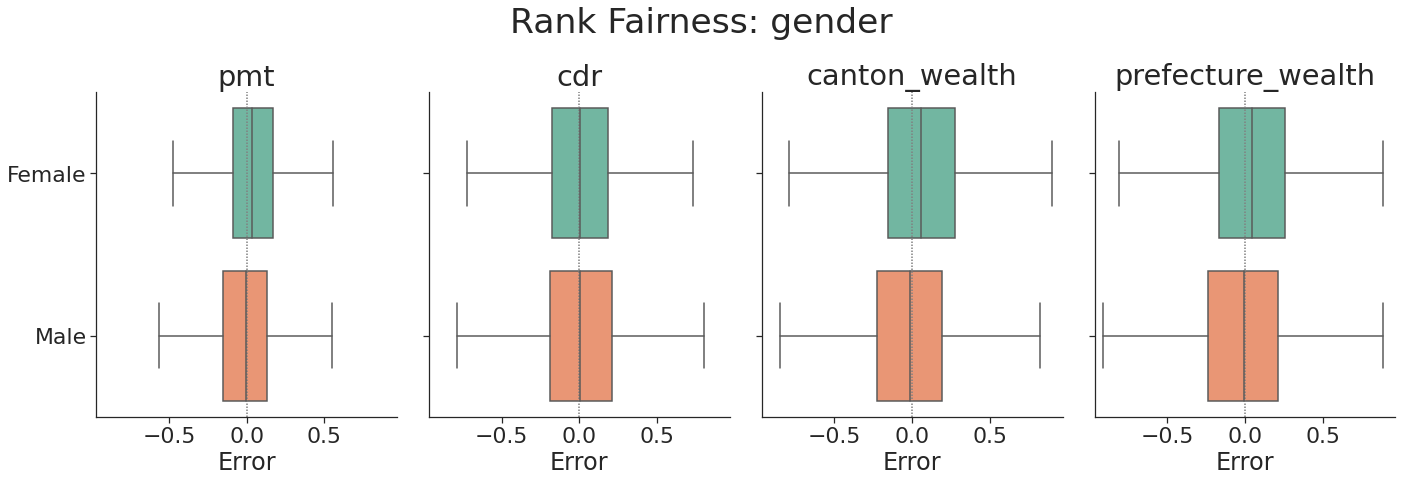

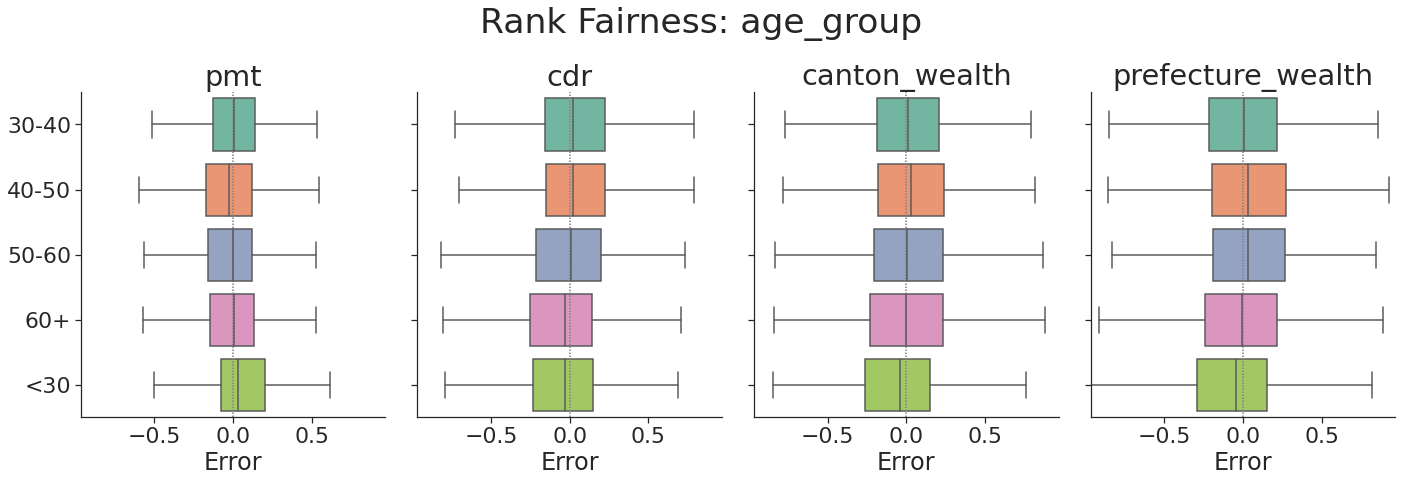

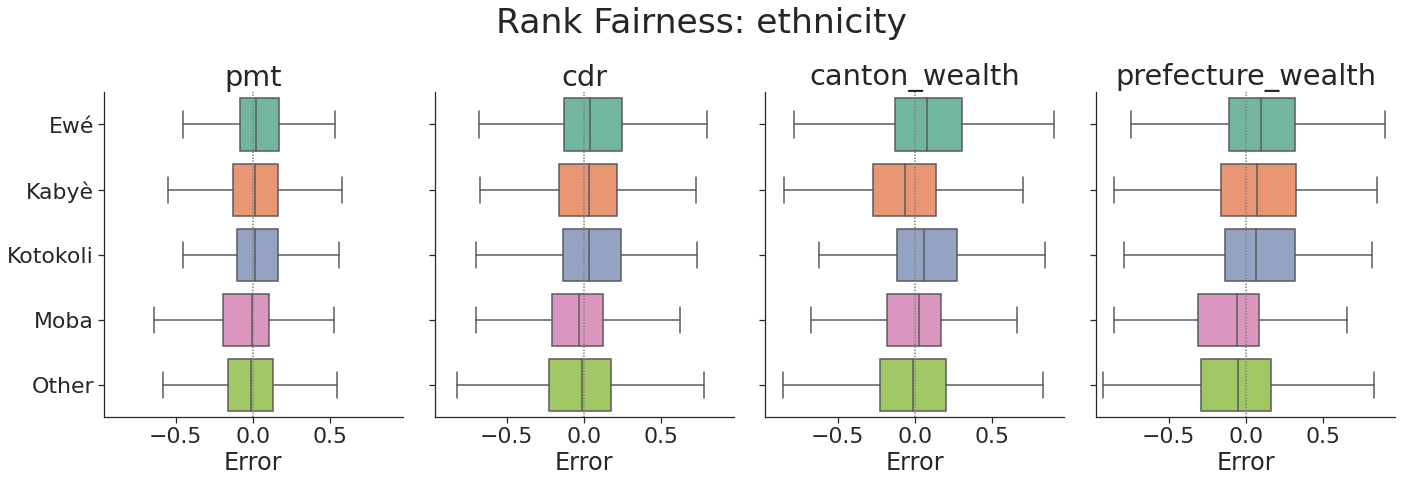

In [10]:
fairness.rank_residuals_plot('consumption', ['pmt', 'cdr', 'canton_wealth',  'prefecture_wealth'], 'gender')
fairness.rank_residuals_plot('consumption', ['pmt', 'cdr', 'canton_wealth',  'prefecture_wealth'], 'age_group')
fairness.rank_residuals_plot('consumption', ['pmt', 'cdr', 'canton_wealth',  'prefecture_wealth'], 'ethnicity')

In [16]:
proxies = ['pmt', 'cdr', 'canton_wealth',  'prefecture_wealth']
fairness.rank_residuals_table('consumption', proxies, 'gender')
fairness.rank_residuals_table('consumption', proxies, 'age_group')
fairness.rank_residuals_table('consumption', proxies, 'ethnicity')

,ethnicity,pmt,cdr,canton_wealth,prefecture_wealth
0,Ewé,0.04 (0.21),0.04 (0.30),0.07 (0.34),0.09 (0.32)
1,Kabyè,0.02 (0.21),0.02 (0.30),-0.07 (0.32),0.08 (0.35)
2,Kotokoli,0.03 (0.22),0.04 (0.29),0.07 (0.29),0.09 (0.31)
3,Moba,-0.04 (0.24),-0.04 (0.29),0.00 (0.28),-0.11 (0.29)
4,Other,-0.02 (0.23),-0.02 (0.31),-0.02 (0.31),-0.06 (0.34)
5,Anova F-Stat,14.5947,10.5211,25.3533,59.2962
6,Anova p-value,7.6775e-12,1.76385e-08,8.82088e-21,9.17499e-49


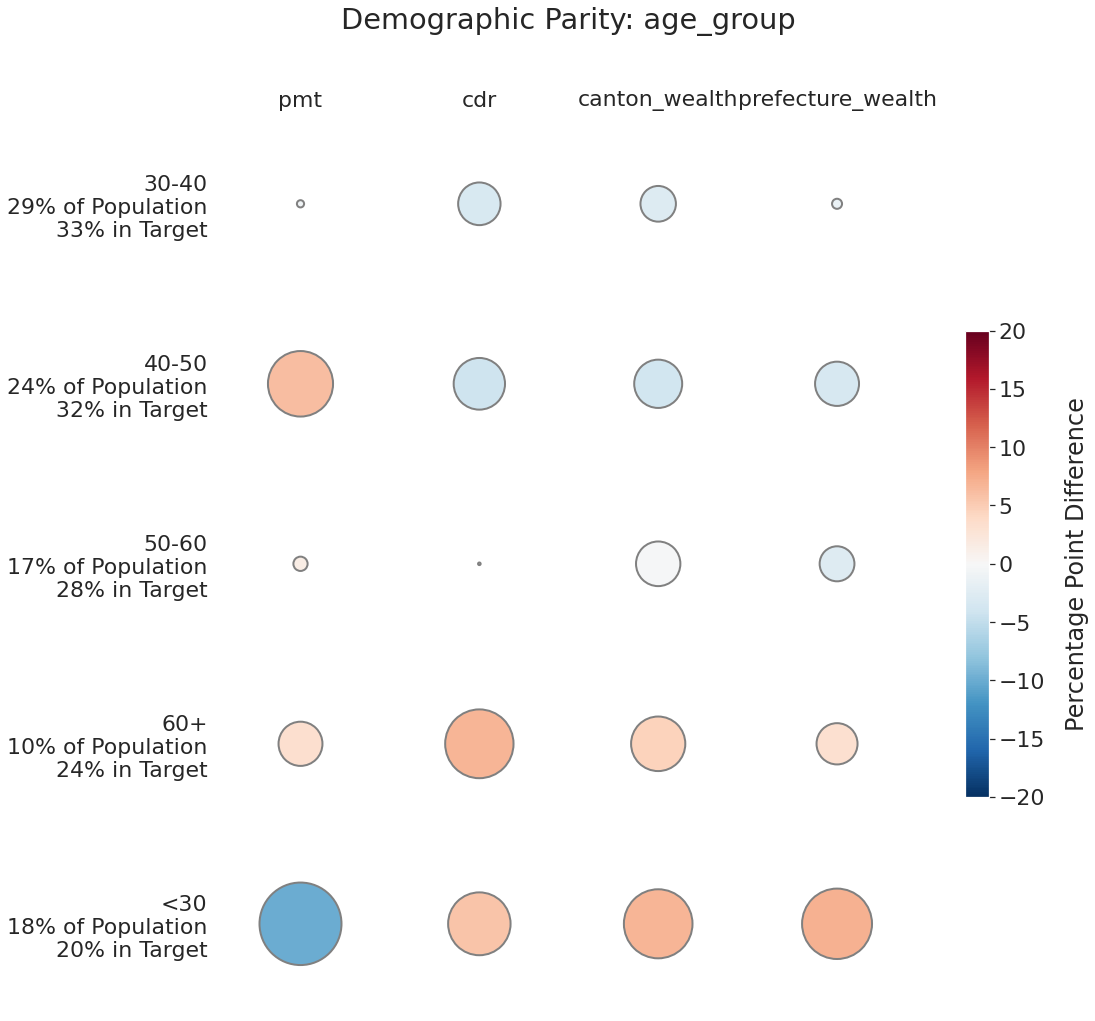

In [22]:
fairness.demographic_parity_plot('consumption', proxies, 'age_group',29, weighted=True)

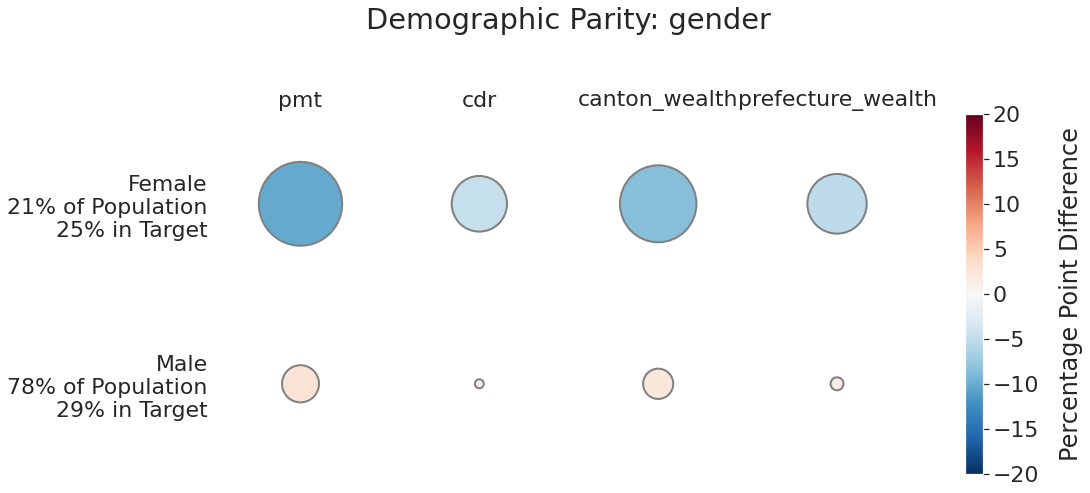

In [3]:
targeting = Targeting('../configs/config_emily.yml')

In [4]:
proxies = ['pmt', 'cdr', 'canton_wealth',  'prefecture_wealth']
targeting.targeting_table('consumption', proxies, p1=29, p2=29, weighted=True)

,Targeting Method,Pearson,Spearman,AUC (Threshold-Agnostic),Accuracy,Precision,Recall,AUC (Threshold-Specific)
0,pmt,0.702258,0.720666,0.849411,0.787192,0.633010,0.633010,0.846703
1,cdr,0.396932,0.446851,0.727987,0.713441,0.505825,0.505825,0.722611
2,canton_wealth,0.295416,0.386148,0.679239,0.698944,0.480825,0.480825,0.696192
3,prefecture_wealth,0.257073,0.335159,0.657651,0.680788,0.449515,0.449515,0.672071


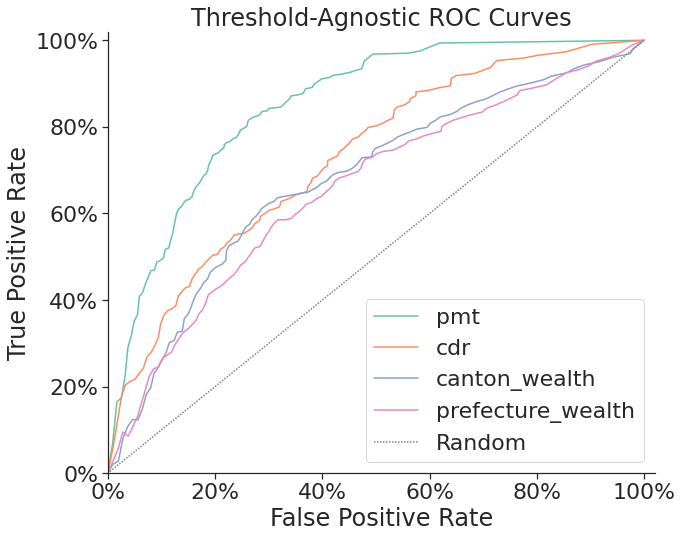

In [7]:
targeting.roc_curves('consumption', proxies, weighted=True)

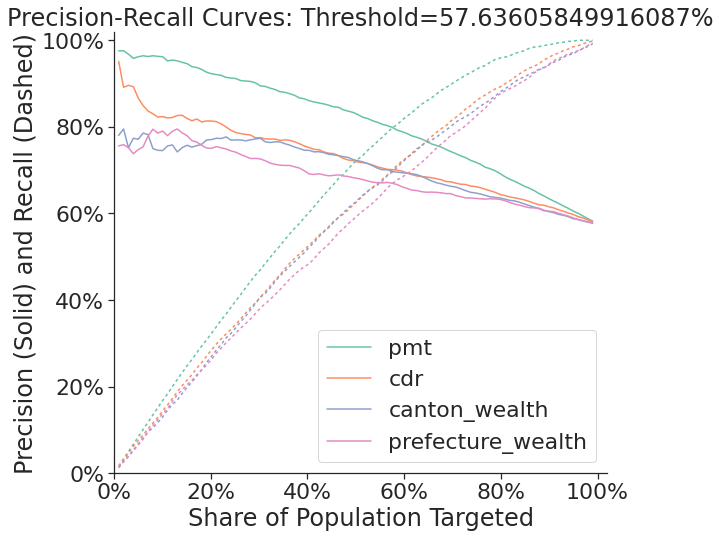

In [10]:
targeting.precision_recall_curves('consumption', proxies, t=1.9, weighted=False)

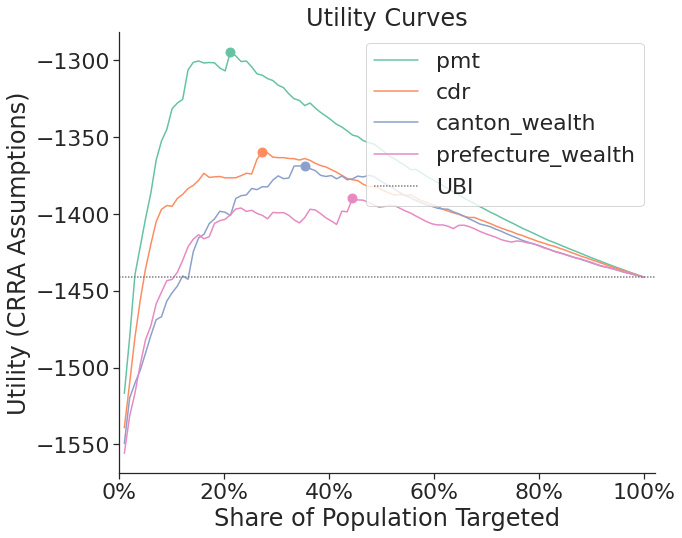

In [12]:
targeting.utility_curves('consumption', proxies, .03, weighted=False)